In [462]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters
import skimage.filters.rank
import skimage.segmentation
import skimage.measure
import skimage.transform
import glob
import random

# Image show

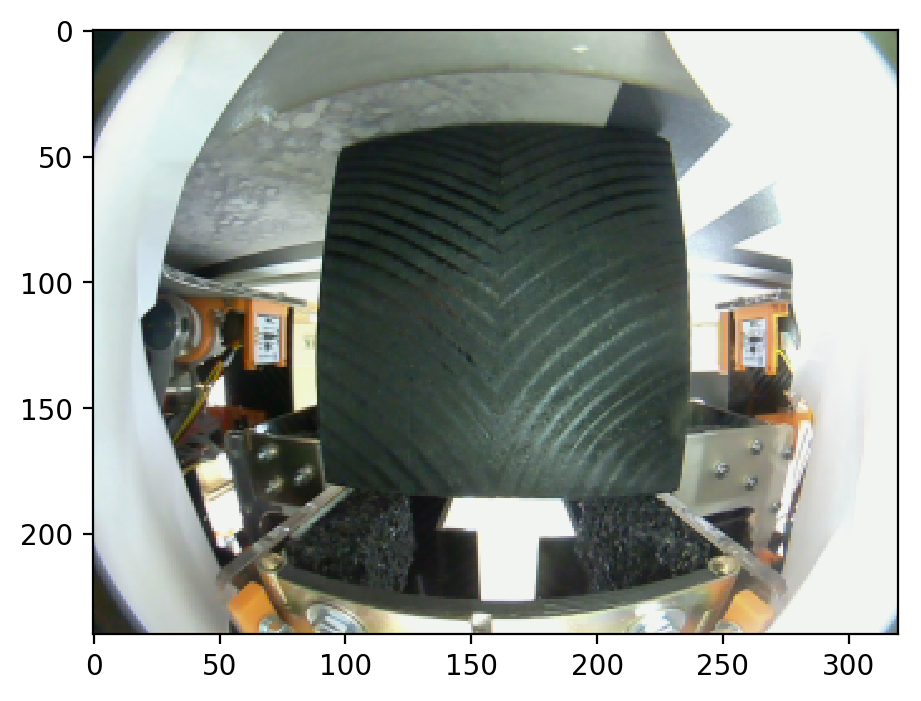

In [593]:
raw_img = cv2.cvtColor(cv2.imread("imgs2/good_2.png"), cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(raw_img);

# Undistorte image

In [594]:
K=np.array([[543.107811968841, 0.0, 630.7227631662455], [0.0, 540.0320855865099, 486.5749791589516], [0.0, 0.0, 1.0]])
D=np.array([[-0.05195582161040964], [-0.009477421485536482], [0.010893416415594874], [-0.005379345567357744]])
K1 = K.copy()
K1[:2] /= 4
K2 = K1.copy()
K2[:2, :2] /= 2

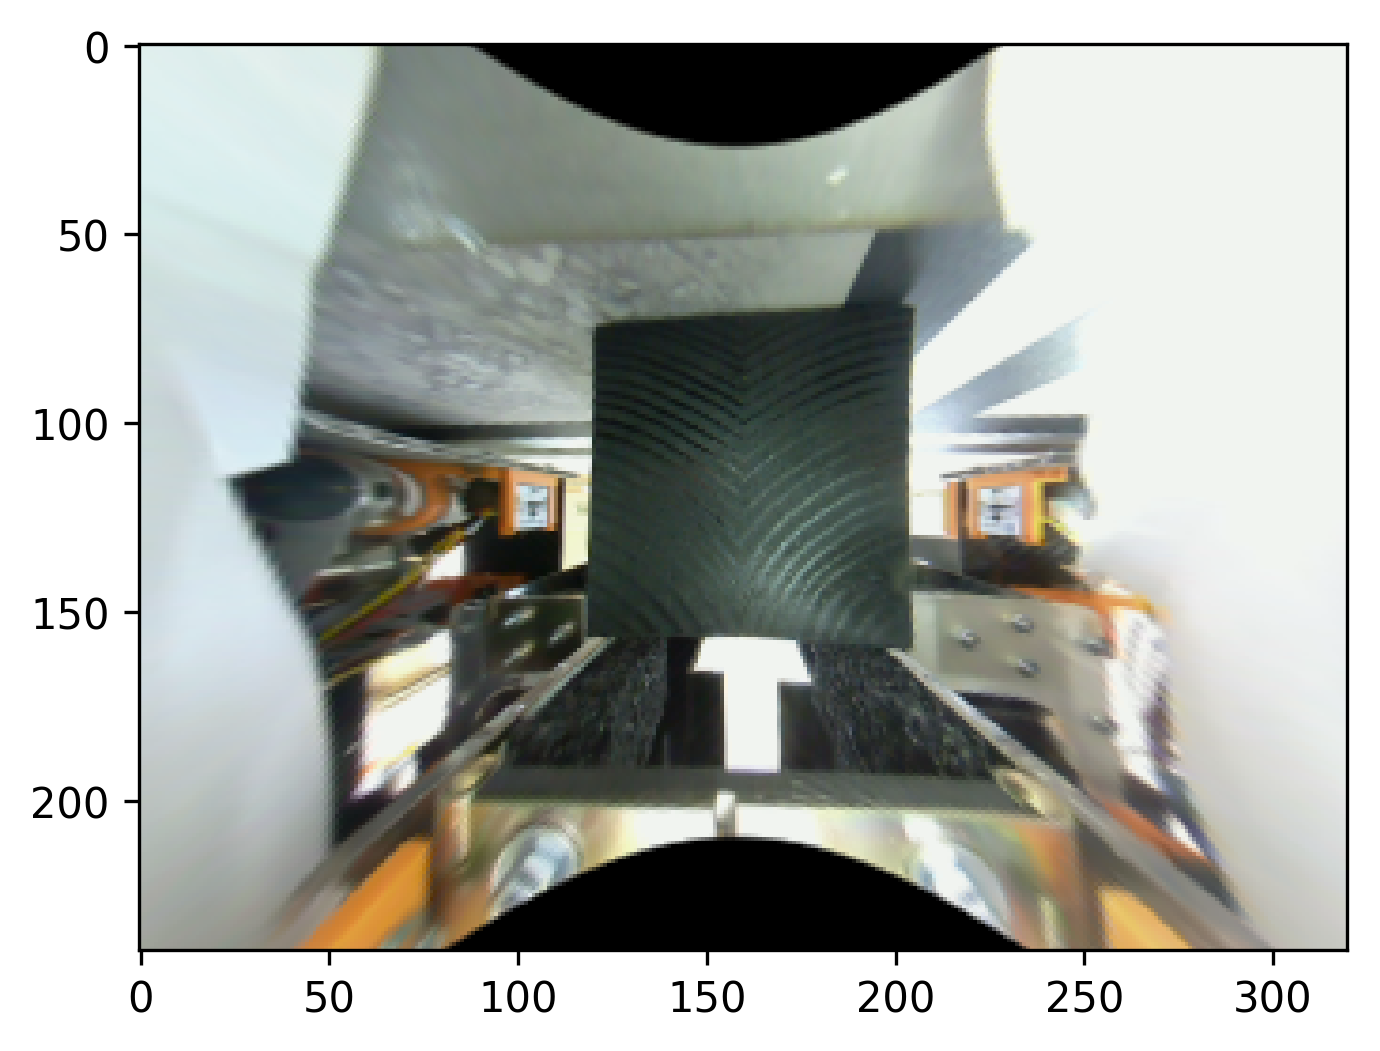

In [595]:
undisort_img = cv2.fisheye.undistortImage(raw_img, K1, D, Knew = K2)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(undisort_img);

# Smoothing

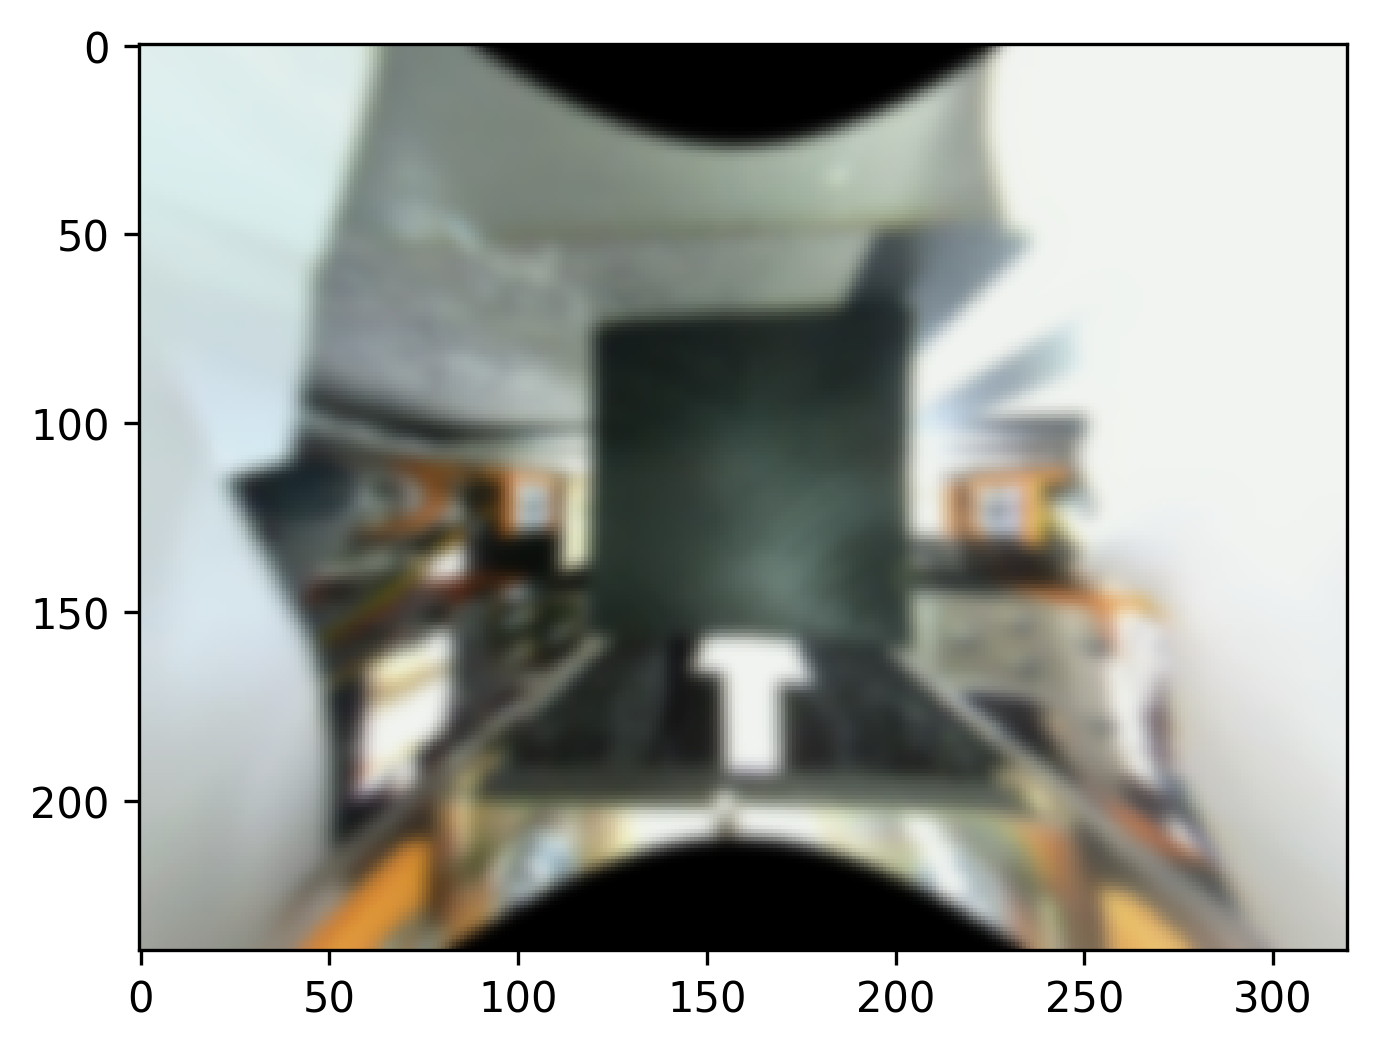

In [649]:
smooth_img = np.zeros_like(undisort_img, dtype=np.float32)
for c in range(3):
    smooth_img[:, :, c] = skimage.filters.gaussian(undisort_img[:, :, c], sigma=2)
smooth_img = (255 * smooth_img).astype(np.uint8)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(smooth_img);

# Gradient

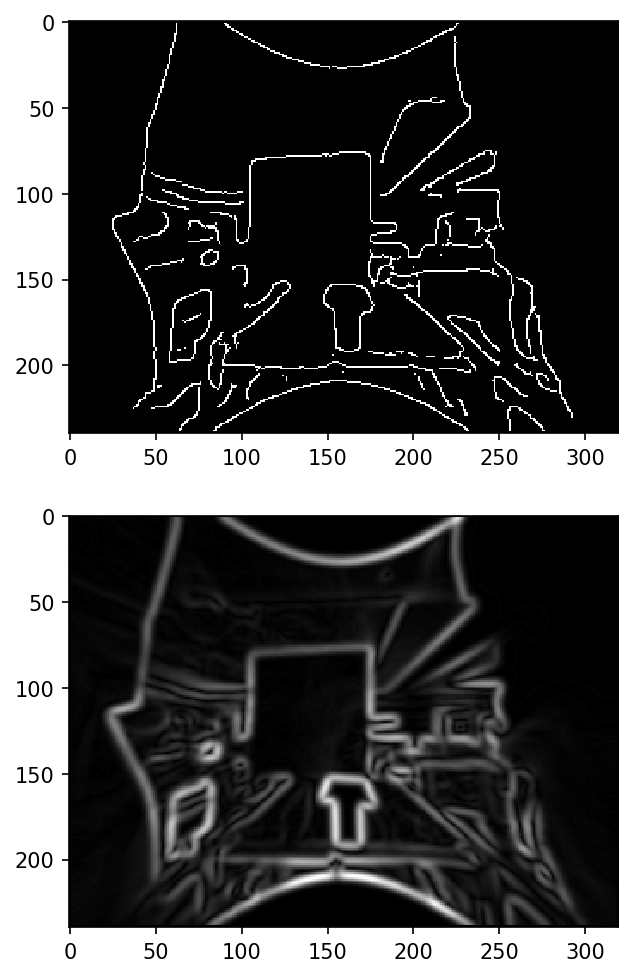

In [533]:
input_img = smooth_img.copy()
edge_roberts = skimage.filters.roberts(cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY))
edge_sobel = skimage.filters.sobel(cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY))
edge_canny = skimage.feature.canny(cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY), sigma=2)
fig, ax = plt.subplots(2, 1, figsize=(6, 8), dpi=150)
ax[0].imshow(edge_canny, cmap="gray");
ax[1].imshow(edge_sobel, cmap="gray");

# Optimization

## Local search in gradient image (rectangle)

In [645]:
DIFF_IND = np.zeros((4, 4 * 4), dtype=np.int32)
for i in range(4):
    DIFF_IND[i, 3 * i: 3 * i + 3] = np.array([3, 2, 1])
    DIFF_IND[i, 3 * 4 + i] = -1

In [647]:
BETA = 20
def edge_cost_func(edge, params):
    mask = np.zeros_like(edge)
    mask[params[0]:params[1], params[2]:params[3]] = 1
    N = np.count_nonzero(mask[:, :])
    n = np.sum(mask * edge)
    return N - n * BETA


def local_search(init_params, edge):
    params = init_params.copy() 
    cost = edge_cost_func(edge, params)
    for i in range(200):
        f = False
        for j in range(diff_ind.shape[1]):
            new_cost = edge_cost_func(edge, params + DIFF_IND[:, j])
            if cost < new_cost:
                params = params + diff_ind[:, j]
                cost = new_cost
                f = True
                break
        if not f:
            break
    return params

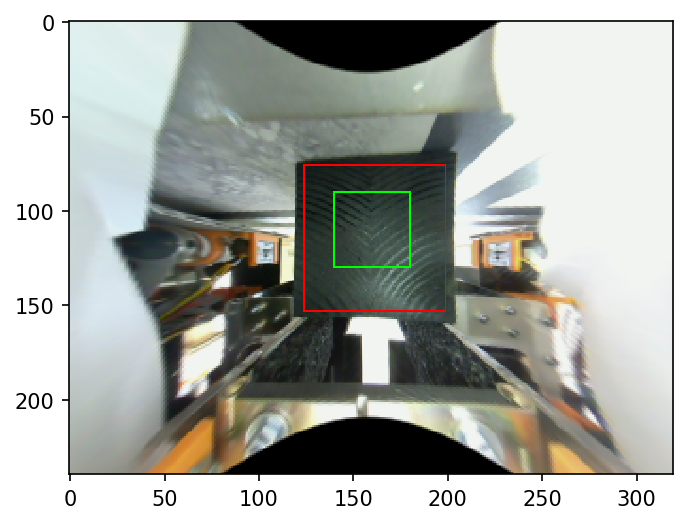

In [652]:
init_params = np.array([90, 130, 140, 180])
edge = 0
for c in range(3):
    edge = edge + skimage.filters.sobel(smooth_img[:, :, c])
params = local_search(init_params, edge)
input_img = undisort_img.copy()
cv2.rectangle(input_img, (params[3], params[1]), (params[2], params[0]), (255, 0, 0))
cv2.rectangle(input_img, (init_params[3], init_params[1]), (init_params[2], init_params[0]), (0, 255, 0))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
plt.imshow(input_img, cmap="gray");

### Many images

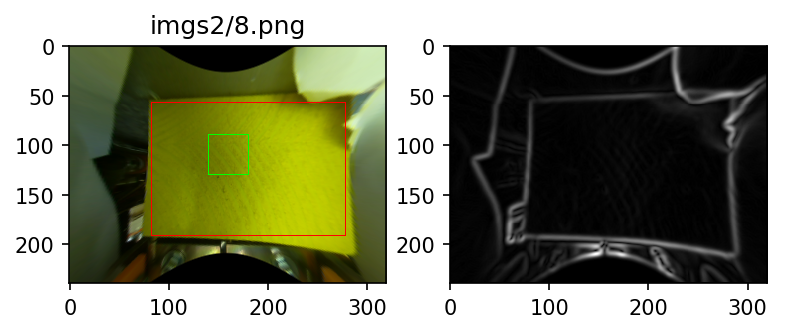

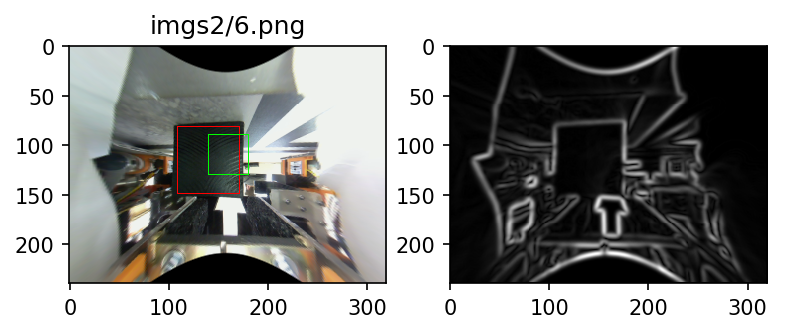

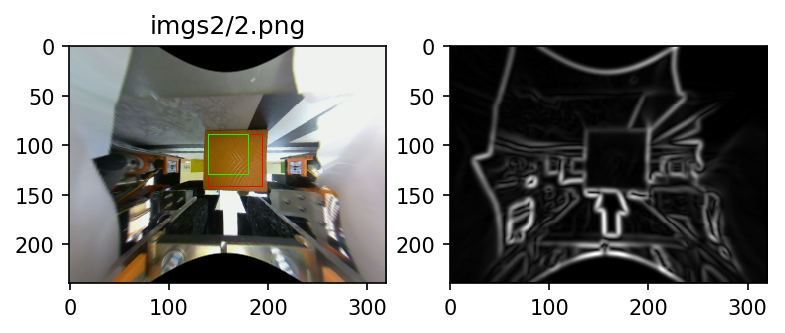

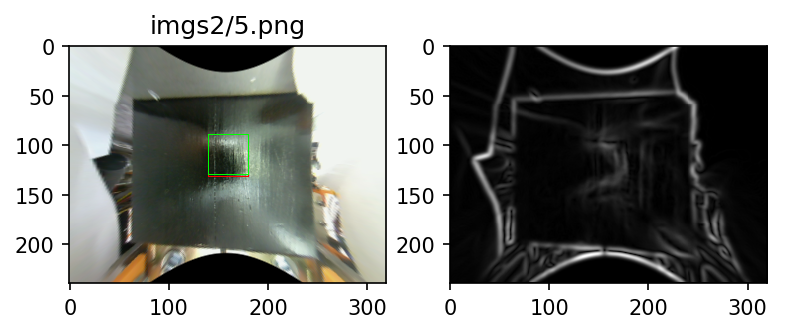

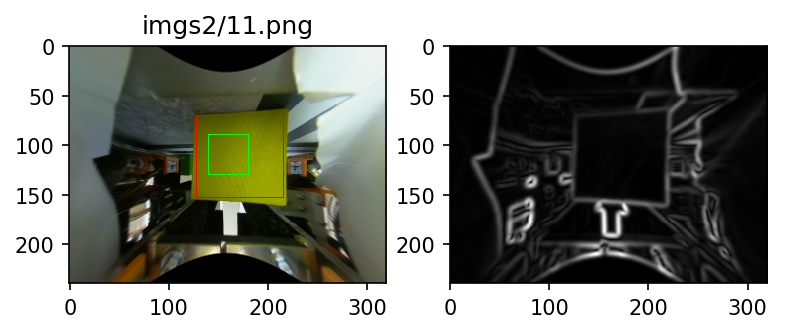

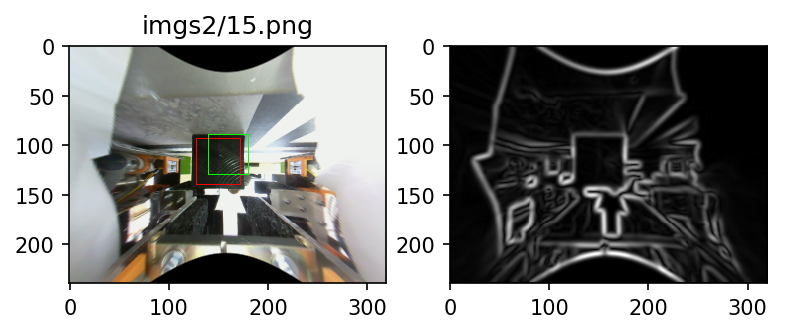

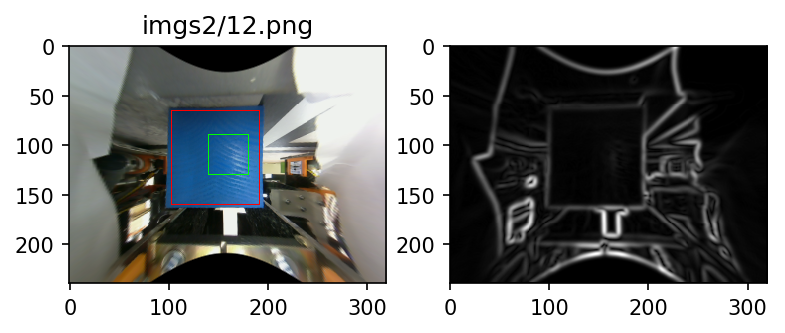

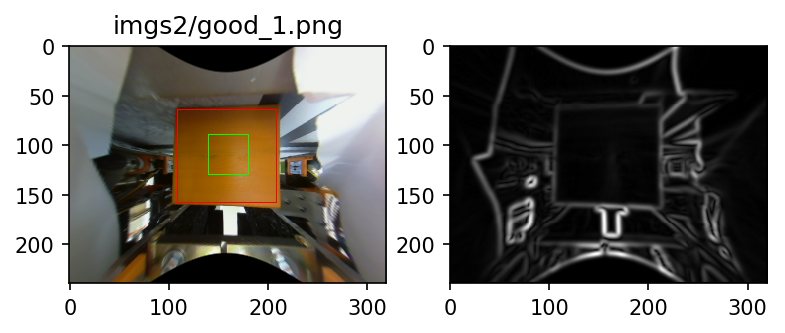

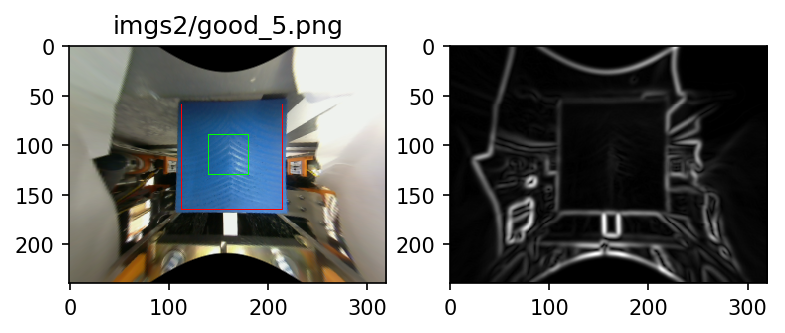

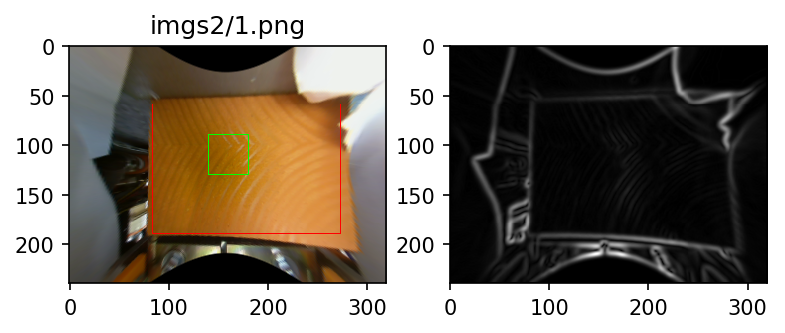

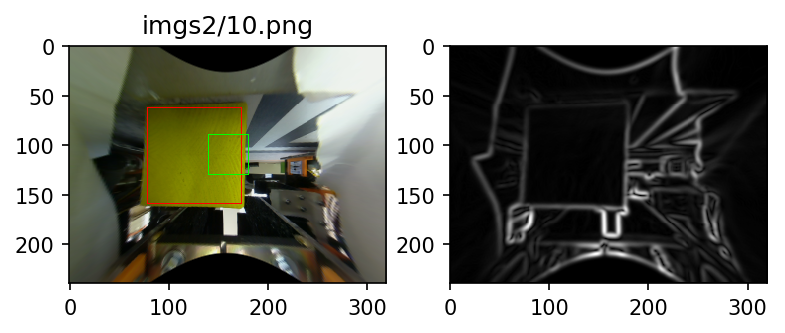

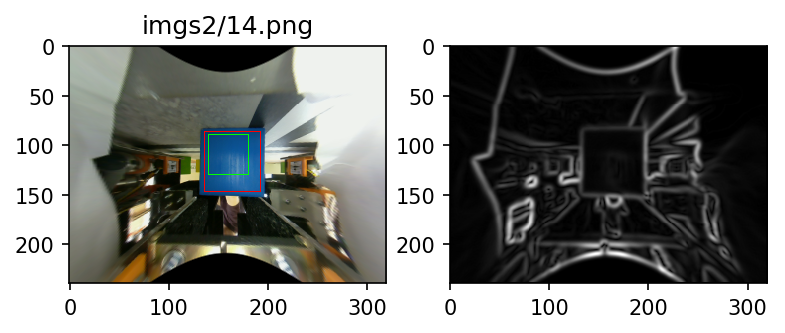

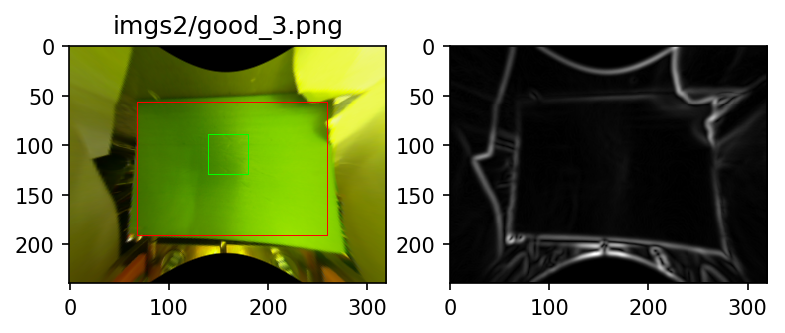

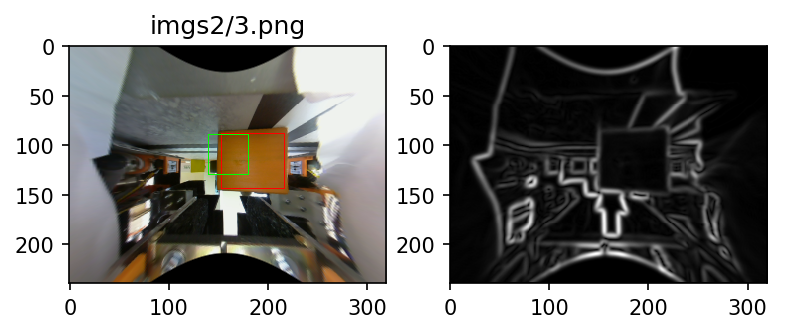

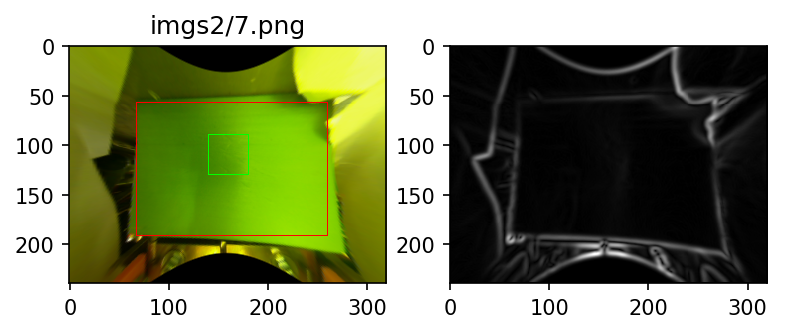

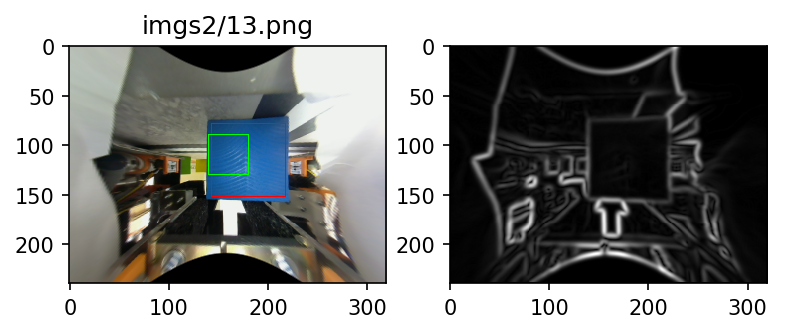

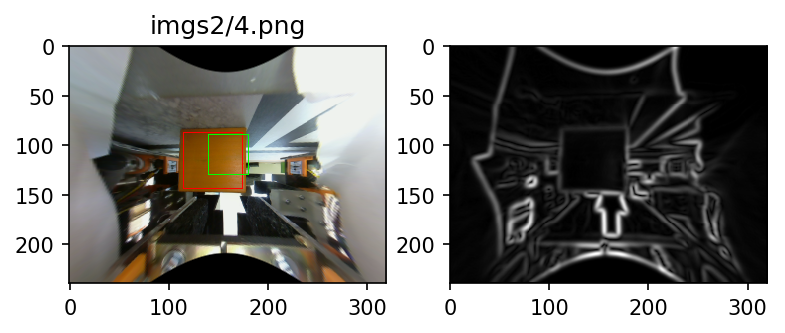

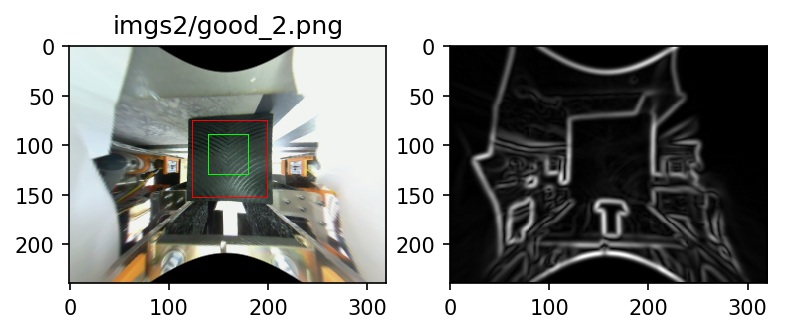

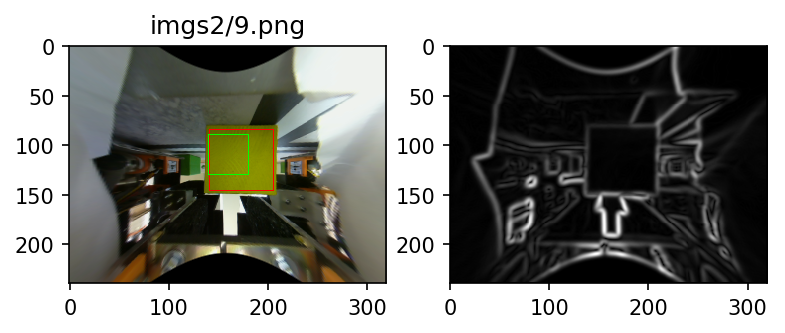

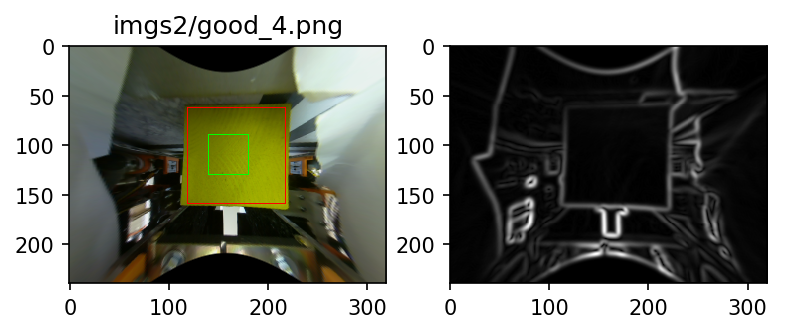

In [662]:
files = glob.glob("imgs2/*.png")
center = (160, 120)
for file in files:
    img1 = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    img2 = cv2.fisheye.undistortImage(img1, K1, D, Knew = K2)
    
    img3 = np.zeros_like(undisort_img, dtype=np.float32)
    for c in range(3):
        img3[:, :, c] = skimage.filters.gaussian(img2[:, :, c], sigma=2)
    img3 = (255 * img3).astype(np.uint8)
    
#    edge = skimage.filters.sobel(cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY))
    edge = 0
    for c in range(3):
        edge = edge + skimage.filters.sobel(img3[:, :, c])
    init_params = np.array([90, 130, 140, 180])
    params = local_search(init_params, edge)
        
    cv2.rectangle(img2, (params[3], params[1]), (params[2], params[0]), (255, 0, 0))
    cv2.rectangle(img2, (init_params[3], init_params[1]), (init_params[2], init_params[0]), (0, 255, 0))
    fig, ax = plt.subplots(1, 2, figsize=(6, 4), dpi=150)
    ax[0].set_title(file)
    ax[0].imshow(img2)
    ax[1].imshow(edge, cmap="gray")
    plt.show()

## Random local search

In [660]:
def get_new_neighbor(params):
    ind = np.random.randint(len(params))
    diff = np.random.randint(13) - 3
    params = params.copy()
    params[ind] += diff
    return params

def random_local_search(init_params, edge):
    params = init_params.copy() 
    cost = edge_cost_func(edge, params)
    for i in range(200):
        new_params = get_new_neighbor(params)
        new_cost = edge_cost_func(edge, new_params)
        if new_cost < cost:
            params = new_params
            cost = new_cost
    return params